# Zadania - regresja logistyczna

### Normalizacja danych

Do danych z ostatnich zajęć (`gratkapl.csv`), podzielonych na zbiór treningowy (pierwsze 4000 elementów) i testowy (ostatnie 1000 elementów) wykonaj następujące polecenia:

1. W zbiorze treningowym usuń elementy odstające, pozostawiając jedynie te przykłady, w których dla każdej cechy $x_i$ zachodzi: $$ \mu_i-n\sigma_i < x_i < \mu_i + n\sigma_i,$$ gdzie $\mu$ to średnia, $\sigma$ to odchylenie standardowe, a $n$ to stała, np. 1 lub 2.
1. Stwórz model regresyjny z wykorzystaniem metody gradientu prostego: jak zachowuje się regresja według ceny bez normalizacji danych? Dla wybranch ustawień stwórz wykres pokazujący wartości funkcji kosztu dla pierwszych $n$ kroków.
1. Dokonaj normalizacji cech wykorzystując standardyzację.
1. Stwórz ponownie model regresyjny na znormalizowanych danych, sprawdź podobne ustawienia i wygeneruj nowe wykresy: jak teraz zachowuje się funkcja kosztu na $n$ kroków?

### Regresja logistyczna

Plik `gratkapl-centrenrm.csv` zawiera dane wzbogacone o nową cechę _Centre_ przyjmującą wartość 1, jeżeli lokalizacja mieszkania to centrum i 0 wpp. Kolumna ta została dodana w sposób automatyczny, na podstawie występowania słowa "centrum" w lokalizacji, jednocześnie słowo to zostało usunięte z opisu lokalizacji. 

Zamiast przywidywania ceny mieszkania, spróbuj przewidzieć lokalizację mieszkania: _centrum_ vs. _nie-centrum_ za pomocą regresji logistcznej.

1. Podziel dane trenujące na nowe dane treningowe (pierwsze 4/5 danych) i testowe (ostatnie 1/5 danych)
1. Stwórz dwuklasowy model regresji logistycznej, korzystając z cech liczbowych _Expected,Rooms,SqrMeters,Floor_. Warto usunąć szum i dokonać normalizacji danych.
1. Podaj procent poprawnych wyników (tzw. skuteczność, _accuracy_) dla zestawu testowego. Otrzymaną wartość porównaj z wynikiem uzyskiwanym przez klasyfikator losowy.
1. Do cech liczbowych, dodaj cechy obliczone na podstawie kolumn _Location_ i _Description_ i ponownie oblicz skuteczność.

### zad.1.1 - odszumianie

In [56]:
import pandas 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

data_all = pandas.read_csv("gratkapl.csv", encoding="utf")

#denoising using standard deviation
data_all = data_all[np.abs(data_all['Expected'] - data_all['Expected'].mean() < data_all['Expected'].std())]

Train, Test = data_all[:4000], data_all[4000:]

### zad.1.2 - wykres funkcji kosztu

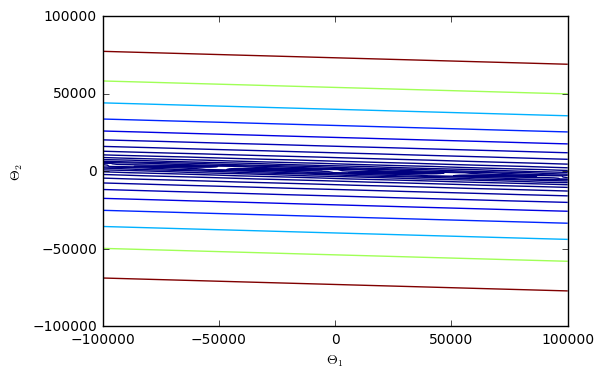

In [57]:
import numpy as np
import pylab as pl

%matplotlib inline

data = np.matrix(data_all[["Rooms","SqrMeters","Expected"]])

m, np1 = data.shape # np1 : n plus 1
n = np1 - 1
Xn = data[:,0:n]

XMx = np.matrix(np.concatenate((np.ones((m, 1)), Xn), axis=1)).reshape(m,np1)
yMx = np.matrix(data[:,-1]).reshape(m,1) / 1000.0

def hMx(theta, X):
    return X*theta

def JMx(theta, X, y):
    m = len(y)
    J = 1.0/(2.0*m)*((X*theta-y).T*(X*theta-y))
    return J.item()

def contourPlot(X, y, rescale=10**10):
    theta0_vals = np.linspace(-100000, 100000, 100)
    theta1_vals = np.linspace(-100000, 100000, 100)

    J_vals = np.zeros(shape=(theta0_vals.size, theta1_vals.size))
    for t1, element in enumerate(theta0_vals):
        for t2, element2 in enumerate(theta1_vals):
            thetaT = np.matrix([1.0, element, element2]).reshape(3,1)
            J_vals[t1, t2] = JMx(thetaT, X, y) / rescale
            
    pl.figure()
    pl.contour(theta0_vals, theta1_vals, J_vals.T, np.logspace(-2, 3, 20))
    pl.xlabel('$\Theta_1$')
    pl.ylabel('$\Theta_2$')

    
contourPlot(XMx, yMx)

### zad.1.3 - normalizacja

In [58]:
XMx_std = (XMx - np.mean(XMx, axis=0)) / np.amax(XMx, axis=0)


### zad.1.4 - wykres funkcji kosztu po normalizacji

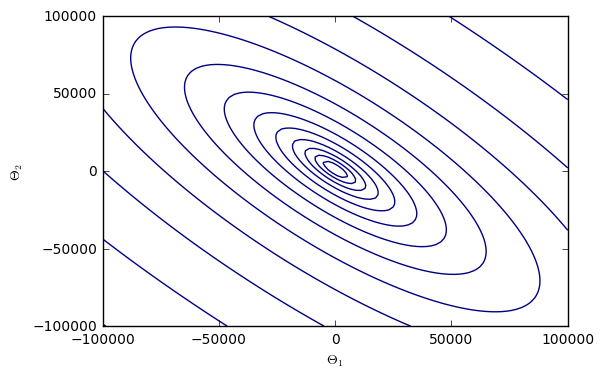

In [59]:
contourPlot(XMx_std, yMx, rescale=10**7)

### zad.2.1 - podział danych

In [60]:
def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.
    return yBi

def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:,i] = mapY(y, cls)
    return Y

data_all = pandas.read_csv("gratkapl-centrenrm.csv", encoding="utf")

#denoising using standard deviation
data_all = data_all[np.abs(data_all['Expected'] - data_all['Expected'].mean() < data_all['Expected'].std())]

m = len(data_all)
X = np.matrix(data_all[["Expected","Rooms","SqrMeters","Floor"]])
X0 = np.ones(m).reshape(m,1)
X = np.hstack((X0, X))
y = np.matrix(data_all[["Centre"]]).reshape(m,1)

# 1-hot matrix
Y = indicatorMatrix(y)

# podział danych na zbiór trenujący i testowy
XTrain, XTest = X[:1608], X[1608:]
YTrain, YTest = Y[:1608], Y[1608:]


### zad.2.2 - dwuklasowy model regresji logistycznej

In [61]:
def dJ(h,theta,X,y):
    return 1.0/len(y)*(X.T*(h(theta,X)-y))

def h(theta, X):
    return 1.0/(1.0 + np.exp(-X*theta))

def J(h, theta, X, y):
    m = len(y)
    h_val = h(theta,X)
    s1 = np.multiply(y, np.log(h_val))
    s2 = np.multiply((1 - y), np.log(1 - h_val))
    return -np.sum(s1 + s2, axis=0) / m


# przygotowanie Y dla regresji binarnej względem klasy 0 lub 1 
testClass = 0
YTrainBi = YTrain[:,testClass]

thetaTemp = np.ones(5).reshape(5,1)

def GD(h, fJ, fdJ, theta, X, y, alpha=0.01, eps=10**-3, maxSteps=10000):
    errorCurr = fJ(h, theta, X, y)
    errors = [[errorCurr, theta]]
    while True:
        # oblicz nowe theta
        theta = theta - alpha * fdJ(h, theta, X, y)
        # raportuj poziom błędu
        errorCurr, errorPrev = fJ(h, theta, X, y), errorCurr
        # kryteria stopu
        if abs(errorPrev - errorCurr) <= eps:
            break
        if len(errors) > maxSteps:
            break
        errors.append([errorCurr, theta]) 
    return theta, errors

# regresja binarna względem klasy ustawionej w testClass
thetaBest, errors = GD(h, J, dJ, thetaTemp, XTrain, YTrainBi, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)

YTestBi = YTest[:,testClass]

def classifyBi(theta, X):
    prob = h(theta, X).item()
    return (1, prob) if prob > 0.5 else (0, prob)


### zad.2.3 - accuracy

In [62]:

acc = 0.0
for i, rest in enumerate(YTestBi):
    cls, prob = classifyBi(thetaBest, XTest[i])
    if i < 10:
        print(int(YTestBi[i].item()), "<=>", cls, "-- prob:", round(prob, 4))
    acc += cls == YTestBi[i].item()

print("\nAccuracy:", acc / len(XTest))

1 <=> 1 -- prob: 1.0
0 <=> 1 -- prob: 1.0
0 <=> 1 -- prob: 1.0
0 <=> 1 -- prob: 1.0
0 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0

Accuracy: 0.7463054187192119


### zad.2.4 - dodanie nowych cech

In [63]:
pandas.options.mode.chained_assignment = None

#first additional feature
df = pandas.DataFrame(data_all['Location'].str.split(' ').tolist())
df = df[1]
x = df.unique()

Dict = {}
for i in range(x.size):
    Dict[x[i]] = i
    
data_all['Weight'] = pandas.DataFrame(df)

data_all['Weight'] = data_all['Weight'].map(Dict)

#second additional feature
data_all['Desc_centrum'] = data_all['Description'].str.contains("centrum")

Dict = {True: 1, False: 0}
data_all['Desc_centrum'] = data_all['Desc_centrum'].map(Dict)


def mapY(y, cls):
    m = len(y)
    yBi = np.matrix(np.zeros(m)).reshape(m, 1)
    yBi[y == cls] = 1.
    return yBi

def indicatorMatrix(y):
    classes = np.unique(y.tolist())
    m = len(y)
    k = len(classes)
    Y = np.matrix(np.zeros((m, k)))
    for i, cls in enumerate(classes):
        Y[:,i] = mapY(y, cls)
    return Y

#denoising using standard deviation
data_all = data_all[np.abs(data_all['Expected'] - data_all['Expected'].mean() < data_all['Expected'].std())]

m = len(data_all)
X = np.matrix(data_all[["Expected","Rooms","SqrMeters","Floor", "Weight", "Desc_centrum"]])
X0 = np.ones(m).reshape(m,1)
X = np.hstack((X0, X))
y = np.matrix(data_all[["Centre"]]).reshape(m,1)

# 1-hot matrix
Y = indicatorMatrix(y)

# podział danych na zbiór trenujący i testowy
XTrain, XTest = X[:1608], X[1608:]
YTrain, YTest = Y[:1608], Y[1608:]


In [64]:
testClass = 0
YTrainBi = YTrain[:,testClass]

thetaTemp = np.ones(7).reshape(7,1)


# regresja binarna względem klasy ustawionej w testClass
thetaBest, errors = GD(h, J, dJ, thetaTemp, XTrain, YTrainBi, 
                       alpha=0.1, eps=10**-7, maxSteps=1000)

YTestBi = YTest[:,testClass]


acc = 0.0
for i, rest in enumerate(YTestBi):
    cls, prob = classifyBi(thetaBest, XTest[i])
    if i < 10:
        print(int(YTestBi[i].item()), "<=>", cls, "-- prob:", round(prob, 4))
    acc += cls == YTestBi[i].item()

print("\nAccuracy:", acc / len(XTest))


1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0
0 <=> 1 -- prob: 1.0
1 <=> 1 -- prob: 1.0

Accuracy: 0.7528089887640449
